In [ ]:
# this workbook is for testing the neural network on a year's data and predicting data for a week

In [1]:
# Libraries

import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn import preprocessing

mpl.rcParams['figure.figsize'] = (20, 10)
mpl.rcParams['axes.grid'] = False

In [3]:
# Reading csv file to dataframe
df = pd.read_csv('islamabad.csv')
df.head(1)

,year,month,day,hour,zone,city,longitude,latitude,aqi,co,...,no2,o3,so2,pm2_5,pm10,nh3,temperature,dewpt,date,smog
0,2021,1,1,0,164,Islamabad,73.0652,33.6938,5,1762.39,...,43.18,33.98,7.21,119.55,139.87,19.51,3.6,-4.3,"January 01, 2021, 12:00 AM",NaN


In [4]:
# converting date time to pandas datetime
date_time=pd.to_datetime(df[['year','month','day','hour']])

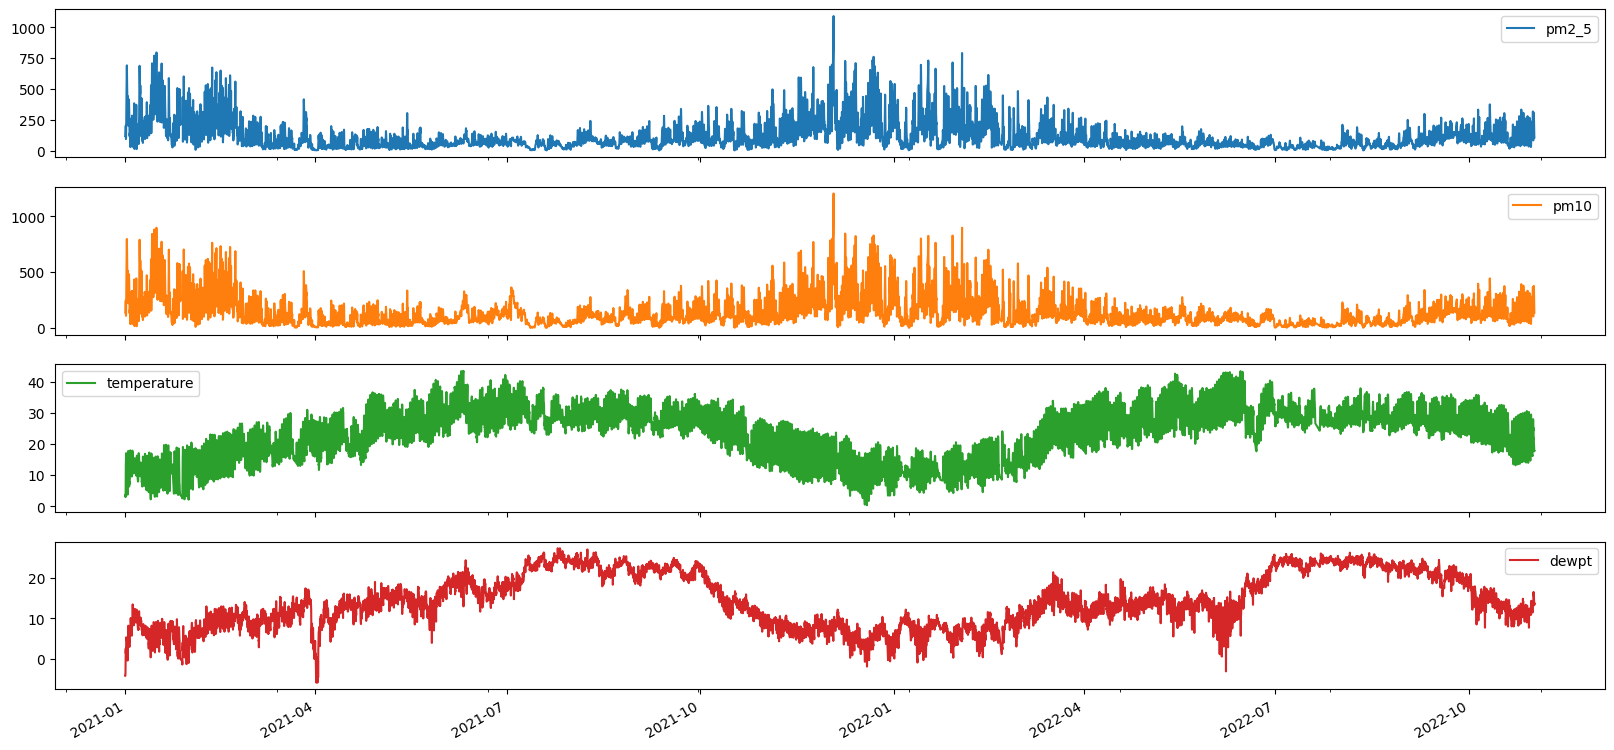

In [6]:
plot_cols = ['pm2_5','pm10','temperature','dewpt']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

([<matplotlib.lines.Line2D at 0x179bbdfd0>],
 <matplotlib.legend.Legend at 0x179be0eb0>)

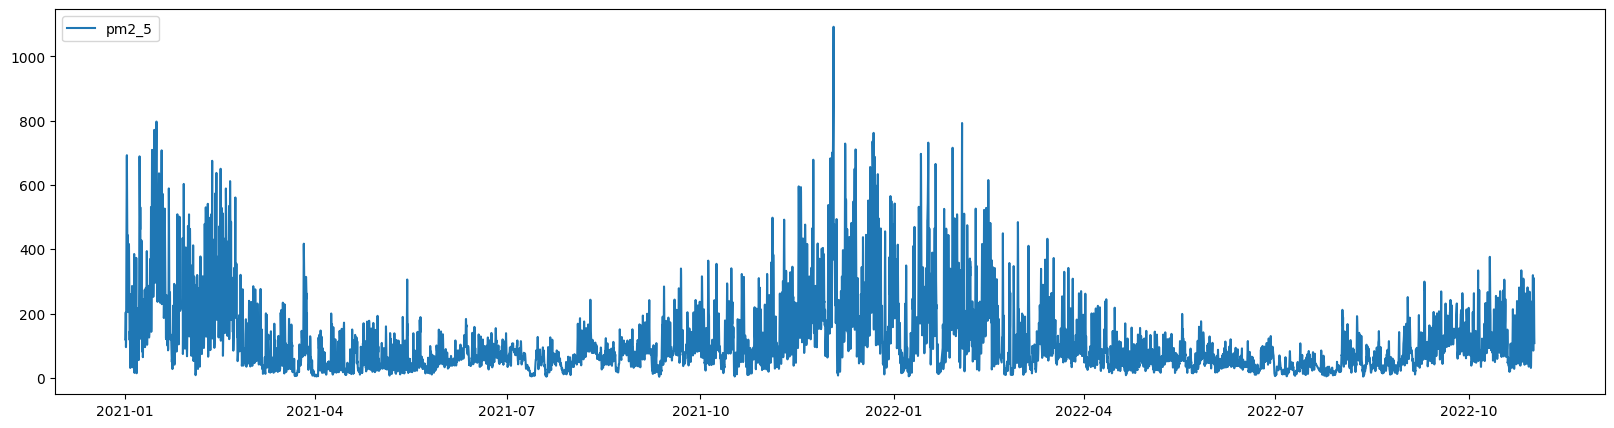

In [7]:
# plotting pm2_5
pm25 = df['pm2_5']
data = date_time
# figure size
plt.figure(figsize=(20, 5))
plt.plot(data, pm25, label = "pm2_5"), plt.legend(loc='upper left')

([<matplotlib.lines.Line2D at 0x17bef0e80>],
 <matplotlib.legend.Legend at 0x1783ca2e0>)

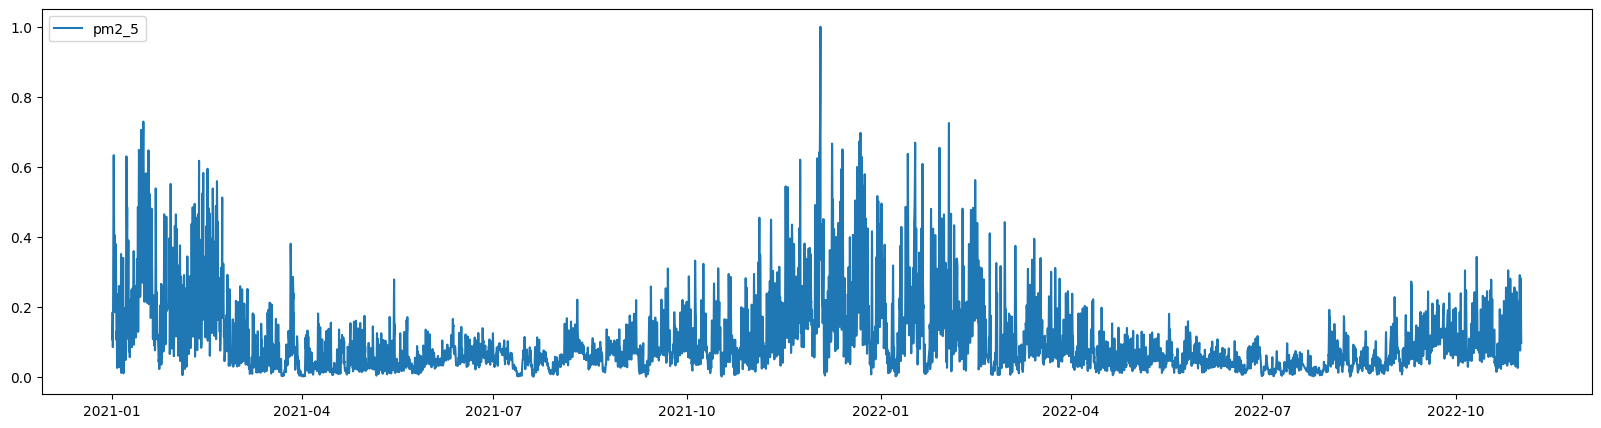

In [9]:
# using lstm to predict pm2_5
# normalizing data
pm25 = df['pm2_5']
pm25 = pm25.values.reshape(-1, 1)
pm25 = preprocessing.MinMaxScaler().fit_transform(pm25)
pm25 = pm25.reshape(-1)
pm25

# plotting normalized pm2_5
data = date_time
# figure size
plt.figure(figsize=(20, 5))
plt.plot(data, pm25, label = "pm2_5"), plt.legend(loc='upper left')

In [10]:
# using all pm2_5 data to predict next 7 days
# splitting data into train and test
train_data = pm25[:int(len(pm25)*0.8)]
test_data = pm25[int(len(pm25)*0.8):]

# function to create dataset
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# reshape to [samples, time_steps, n_features]
TIME_STEPS = 7
X_train, y_train = create_dataset(train_data, train_data, TIME_STEPS)
X_test, y_test = create_dataset(test_data, test_data, TIME_STEPS)

# reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [11]:
# build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

2022-12-06 23:55:08.786394: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-06 23:55:08.786993: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [12]:
# train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=16, validation_split=0.1, shuffle=False)

Epoch 1/5


2022-12-06 23:55:12.692659: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-06 23:55:13.422320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-06 23:55:13.609799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-06 23:55:13.843629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


717/717 [==============================] - ETA: 0s - loss: 0.0037

2022-12-06 23:55:25.917511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-06 23:55:25.982142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


717/717 [==============================] - 14s 17ms/step - loss: 0.0037 - val_loss: 1.8412e-04
Epoch 2/5
717/717 [==============================] - 11s 15ms/step - loss: 0.0013 - val_loss: 1.3565e-04
Epoch 3/5
717/717 [==============================] - 10s 14ms/step - loss: 0.0010 - val_loss: 1.2654e-04
Epoch 4/5
717/717 [==============================] - 10s 14ms/step - loss: 8.9353e-04 - val_loss: 1.2807e-04
Epoch 5/5
717/717 [==============================] - 10s 14ms/step - loss: 8.3579e-04 - val_loss: 1.2832e-04


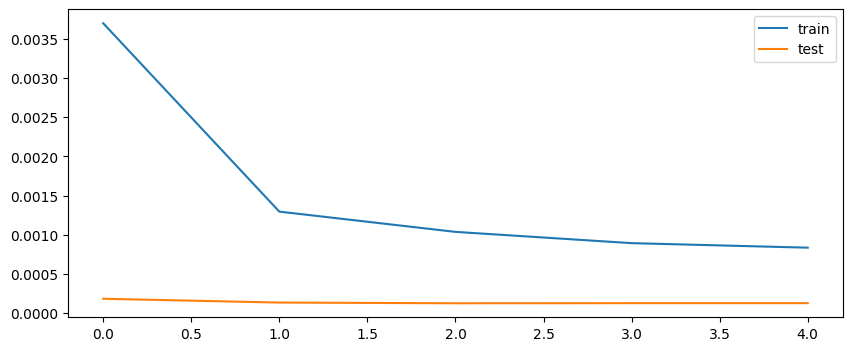

In [13]:
# plot loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

 10/100 [==>...........................] - ETA: 0s 

2022-12-06 23:56:36.522965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-06 23:56:36.588339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 1s 5ms/step


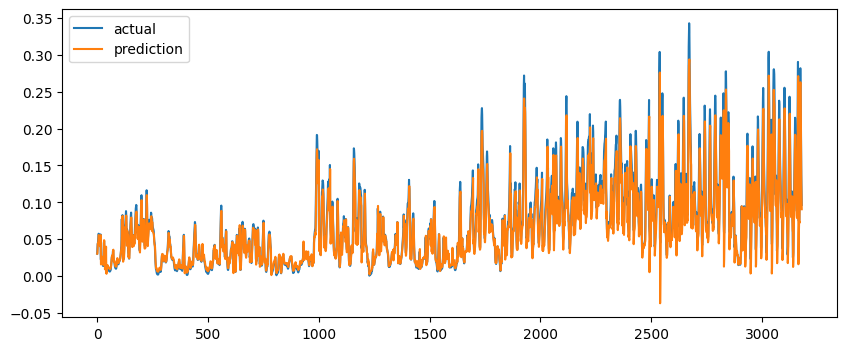

In [14]:
# predict
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)

# plot predictions
plt.figure(figsize=(10, 4))
plt.plot(y_test, label='actual')
plt.plot(y_pred, label='prediction')
plt.legend()
plt.show()

In [15]:
# function to predict next 7 days
def predict_next_days(model, X_test, y_test, days):
    y_pred = model.predict(X_test)
    y_pred = y_pred.reshape(-1)
    y_test = y_test.reshape(-1)
    for i in range(days):
        X_test = np.append(X_test, y_pred[-1])
        X_test = X_test[1:]
        X_test = X_test.reshape(1, X_test.shape[0], 1)
        y_pred = np.append(y_pred, model.predict(X_test))
        y_pred = y_pred.reshape(-1)
    return y_pred

In [16]:
# predict next 7 days
y_pred = predict_next_days(model, X_test, y_test, 1)

# plot predictions
# plt.figure(figsize=(10, 4))

# plt.plot(y_test, label='actual')
# plt.plot(y_pred, label='prediction')
# plt.legend()
# plt.show()

100/100 [==============================] - 0s 5ms/step


2022-12-06 23:57:08.111649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-06 23:57:08.178345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
